In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

import numpy as np
import cv2
from PIL import Image

import os
from options.test_options import TestOptions
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
## TODO: put these helper function to an own file

def to_image(tensor, nrow=8, padding=2,
               normalize=False, range=None, scale_each=False, pad_value=0):
    """from torchvision utils: converts a given Tensor into an image file.

    Args:
        tensor (Tensor or list): Image to be saved. If given a mini-batch tensor,
            saves the tensor as a grid of images by calling ``make_grid``.
        **kwargs: Other arguments are documented in ``make_grid``.
    """
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    im = Image.fromarray(ndarr)
    return im

def concatenate(images):
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    result = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
        result.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return result

### Setup the webcam and the latest model

In [5]:
# TODO: hide this stuff too

framesize = 600

# setup cyclegan model using the training options:
opt = TrainOptions().parse()
# hard-code some parameters for demo
opt.num_threads = 1
opt.batch_size = 1
opt.serial_batches = True
opt.no_flip = True
opt.display_id = -1
opt.phase = 'test'
opt.epoch = 'latest'

# hack a bit to get it up and running:
opt.isTrain = False
model = create_model(opt)
model.isTrain = False
model.setup(opt)

# setup dataset
dataset = create_dataset(opt)


#camera = cv2.VideoCapture(0)
#time.sleep(0.1)     # time to load the camera
#framesize = 304     # according to the models input size

#_, image = camera.read()
#height, width, _ = image.shape
#crop_pixel = int((width - height)/2) # crop square
#cropped_frame = image[:, crop_pixel:width-crop_pixel]
#resized_frame = cv2.resize(cropped_frame, (framesize, framesize)) 

#cv2.imwrite('webcam_image/webcam.png', resized_frame)
#del(camera)

#plt.imshow(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))
#plt.title('Captured image')
#plt.axis('off')
#plt.show()

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./datasets/faces              
             dataset_mode: face                          
                direction: AtoB                          
              display_env: main                          
             display_freq: 100                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1  

### Convert faces to cartoons (forward pass through the network)

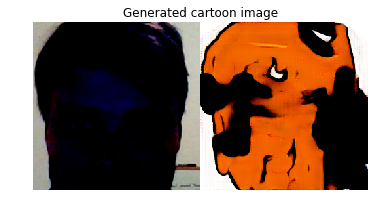

In [7]:
from IPython.display import clear_output

# set the brightness in order to enhance captures in a 
# dark environment (default 0.5)
brightness = 0.3 # lower enhances darker environments

# capture on webcam
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1);
# use the hflip for "demirrored" webcams
transform = transforms.Compose([torchvision.transforms.functional.hflip,
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize((brightness, brightness, brightness),
                                                (0.5, 0.5, 0.5))])

try:
    while(True):
        # drop capture buffer (the easy way)
        ret, frame = cap.read()
        ret, frame = cap.read()
        ret, frame = cap.read()

        # scale the image and convert to RGB
        hight, width, depth = frame.shape
        crop_pixel = int((width - hight)/2) # crop square
        cropped_frame = frame[:, crop_pixel:width-crop_pixel]
        resized_frame = cv2.resize(cropped_frame, (framesize, framesize))
        cvframe = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB) 

        # transform the capture to an PIL image
        pil_img = Image.fromarray(cvframe)
        img = transform(pil_img)
        img = img.view(1, 3, 256, 256)
        img_A = to_image(img[0, :, :, :])
        img_B = model.gen_B(img)
        #torchvision.utils.save_image(img_B[0, :, :, :], 'comic.png')
        img_B = to_image(img_B[0, :, :, :])
        img_AB = concatenate([img_A, img_B])
        img_AB.save('comic.jpg')

        clear_output()    
        plt.axis('off')
        plt.title('Generated cartoon image')
        plt.imshow(img_AB)
        plt.show()
    
except KeyboardInterrupt:
    # you have to interrupt the kernel to break the loop:
    cap.release()
   


If the image is too dark, put a lamp in front of your face (classical computer vision trick). You can finetune with the brightness property.

### Bonus: convert cartoons to faces

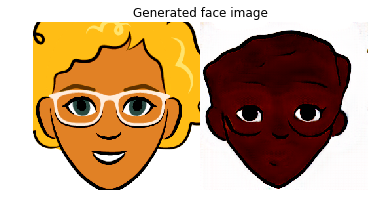

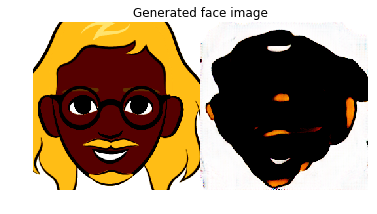

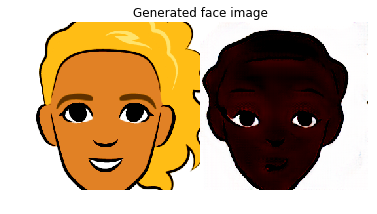

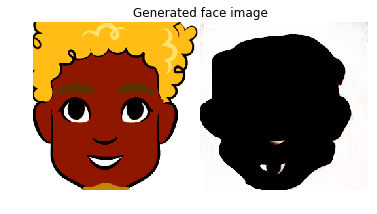

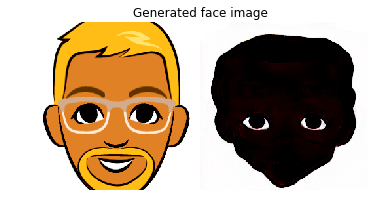

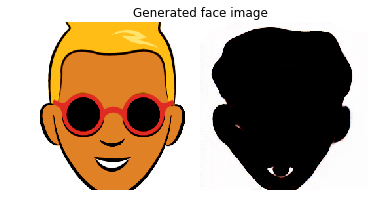

In [8]:
for i, data in enumerate(dataset):
    if (i > 5):
        break
    
    theB = data['B']
    real_B = theB['img']
    img_B = to_image(real_B[0,:,:,:])
    img_A = model.gen_A(real_B)
    img_A = to_image(img_A[0,:,:,:])
    img_BA = concatenate([img_B, img_A])
    img_BA.save('real.jpg')
    
    plt.axis('off')
    plt.title('Generated face image')
    plt.imshow(img_BA)
    plt.show()
    

In [ ]:
## demo code to have a slider for the conditional version

import ipywidgets as wg
import matplotlib.pyplot as plt

class interactive_plot:

    def __init__(self,r):
        self.X = [x for x in range(r)]
        self.Y = [y for y in range(r)]
        self.r = r
        self.fig = None
        self.ax = None

    def pathPlot(self, xframe = None):

        if self.fig is None:
            self.fig = plt.figure()
            self.ax =self.fig.add_subplot(1,1,1)
            self.ax.plot(self.X, self.Y, 'bo-')

        else:
            self.fig = plt.gcf()
            self.ax = plt.gca()
            self.ax.plot(self.X, self.Y, 'bo-')

        if xframe is not None:
            self.ax.axvline(x = self.X[xframe],color = 'black',linestyle = '--')
            self.ax.plot(self.X[xframe],self.Y[xframe], 'ro', markersize=10)

    def pathPlay(self):

        frame = wg.IntSlider(min = 0, max = self.r - 1)
        wg.interact(self.pathPlot, xframe = frame)

test = interactive_plot(10)
test.pathPlay()

### Forward pass (pseudo code)

In [ ]:
#import network_architecture.py

#state_dict = torch.load('saved_model/latest_net_G.pth')
#model = network_architecture.network()   # Load from external python file
#model.load_state_dict(state_dict)

#cartoon_img = model('webcam_image/webcam')
#cv2.imwrite('cartoon_image/webcam_cartoon_image.png', cartoon_img)

### Show image

In [ ]:
cartoon_image = cv2.imread('cartoon_image/webcam_cartoon_image.png')
plt.axis('off')
plt.title('Generated cartoon image')
plt.imshow(cv2.cvtColor(cartoon_image, cv2.COLOR_BGR2RGB))
plt.show()